In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

2022-11-27 02:57:21.610056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 02:57:22.363345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/appdrive/mambaforge/envs/py37_tensorflow/lib/
2022-11-27 02:57:22.363438: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/appdrive/mambaforge/envs/py37_tensorflow/lib/
2022-11-27 02:57:22.363446: W tens

In [2]:
import yaml
import missingno as mn

# Data Loading

In [3]:
# df = pd.read_csv('/home/geouser05/geo/notebooks/prediction_dts.csv')
# df = pd.read_csv('/home/geouser05/geo/data/02_preprocessed/well_logs.csv')
df = pd.read_csv('/home/geouser05/geo/data/07_model_output/prediction_dts_full2.csv')
df = df.iloc[:, 1:].copy()

In [4]:
df.head()

,DEPT,BS,CALI,DEPTH_MD,DRHO,DTC,DTS,FORCE_2020_LITHOFACIES_CONFIDENCE,FORCE_2020_LITHOFACIES_LITHOLOGY,GR,...,NPHI_PRED_MICE,DTC_PRED_MICE,RHOB_PRED_MICE,GR_PRED_MICE_2,NPHI_PRED_MICE_2,DTC_PRED_MICE_2,RHOB_PRED_MICE_2,DTS_PRED_MICE2_LGBM,DTS_PRED_MICE2_LGBM_025,DTS_PRED_MICE2_LGBM_975
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.019744,-0.349258,0.110261,-0.000002,-0.011942,-0.345211,0.111783,238.9837,202.109088,275.894012
1,362.4024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.019744,-0.349258,0.110261,-0.000002,-0.011942,-0.345211,0.111783,238.9837,202.109088,275.894012
2,362.5548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.019744,-0.349258,0.110261,-0.000002,-0.011942,-0.345211,0.111783,238.9837,202.109088,275.894012
3,362.7072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.019744,-0.349258,0.110261,-0.000002,-0.011942,-0.345211,0.111783,238.9837,202.109088,275.894012
4,362.8596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.019744,-0.349258,0.110261,-0.000002,-0.011942,-0.345211,0.111783,238.9837,202.109088,275.894012


In [5]:
df.shape

(2213086, 66)

In [13]:

features_base = [
            # 'CALI', 
            # 'DRHO', 
            'DTC', 
            # 'FORCE_2020_LITHOFACIES_CONFIDENCE', 
            #'FORCE_2020_LITHOFACIES_LITHOLOGY',
            'GR', 
            'NPHI', 
            # 'PEF', 
            #'RDEP', 
            'RHOB', 
            #'RMED', 
            # 'ROP',
            # 'RSHA', 
            # 'RXO', 
            # 'SP', 
            # 'RMIC', 
            # 'SGR', 
            # 'ROPA', 
            # 'DCAL',
            # 'MUDWEIGHT'
            ]
features_one_hot_encode = ['FORCE_2020_LITHOFACIES_LITHOLOGY']
features_scale = ['GR', 'NPHI', 'DTC', 'RHOB'] #list(set(features_base) - set(features_one_hot_encode))
target = 'DTS'
n = 50

In [14]:
with open('/home/geouser05/geo/conf/parameters.yml', 'r') as file:
    parameters = yaml.safe_load(file)
raw_filenames = parameters['filename_dts']
def process_filename(x):
    return x.replace('/', '_').replace(' ', '_') + '_logs.las'
filenames = [process_filename(x) for x in raw_filenames]

In [15]:
# Split well for train and test
test_idx = [3, 22,  5, 33, 35,  0, 20,  5]
train_idx = list(set(range(len(filenames))) - set(test_idx))

# Create train and test dataframes
def get_filename(df, f_list, idx_list):
    f_list = [x for i, x in enumerate(f_list) if i in idx_list]
    return df[df.filename.isin(f_list)].copy()

df_train = get_filename(df, filenames, train_idx)
df_test = get_filename(df, filenames, test_idx)

# Data Preprocessing

In [16]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pickle

In [17]:
## One hot encoding

In [18]:
if False:
    enc = OneHotEncoder(sparse = False)
    enc.fit(df[features_one_hot_encode])

    with open('/home/geouser05/geo/data/06_model/onehot_encoder.pkl', 'wb') as file:
        pickle.dump(enc, file)

    scaler = StandardScaler()
    scaler.fit(df_train[features_scale])

    with open('/home/geouser05/geo/data/06_model/scale.pkl', 'wb') as file:
        pickle.dump(scaler, file)
else:
    with open('/home/geouser05/geo/data/06_model/onehot_encoder.pkl', 'rb') as file:
        enc = pickle.load(file)
    encoded_columns = list(enc.categories_[0])[:-1]

    with open('/home/geouser05/geo/data/06_model/scale.pkl', 'rb') as file:
        scaler = pickle.load(file)
    

In [19]:
# Transform dataset
df_preprocessed = df.copy()

# df_encode = enc.transform(df[features_one_hot_encode])
# encoded_columns = list(enc.categories_[0])
# df_preprocessed[encoded_columns] = df_encode
# encoded_columns = encoded_columns[:-1]

df_scaled = scaler.transform(df[features_scale])
df_preprocessed[features_scale] = df_scaled 

In [21]:
features = features_scale #+ encoded_columns
n_features = len(features) + 1

# EDA

In [22]:
df_filter = df[df_preprocessed .filename.isin(filenames)].copy()

<AxesSubplot:>

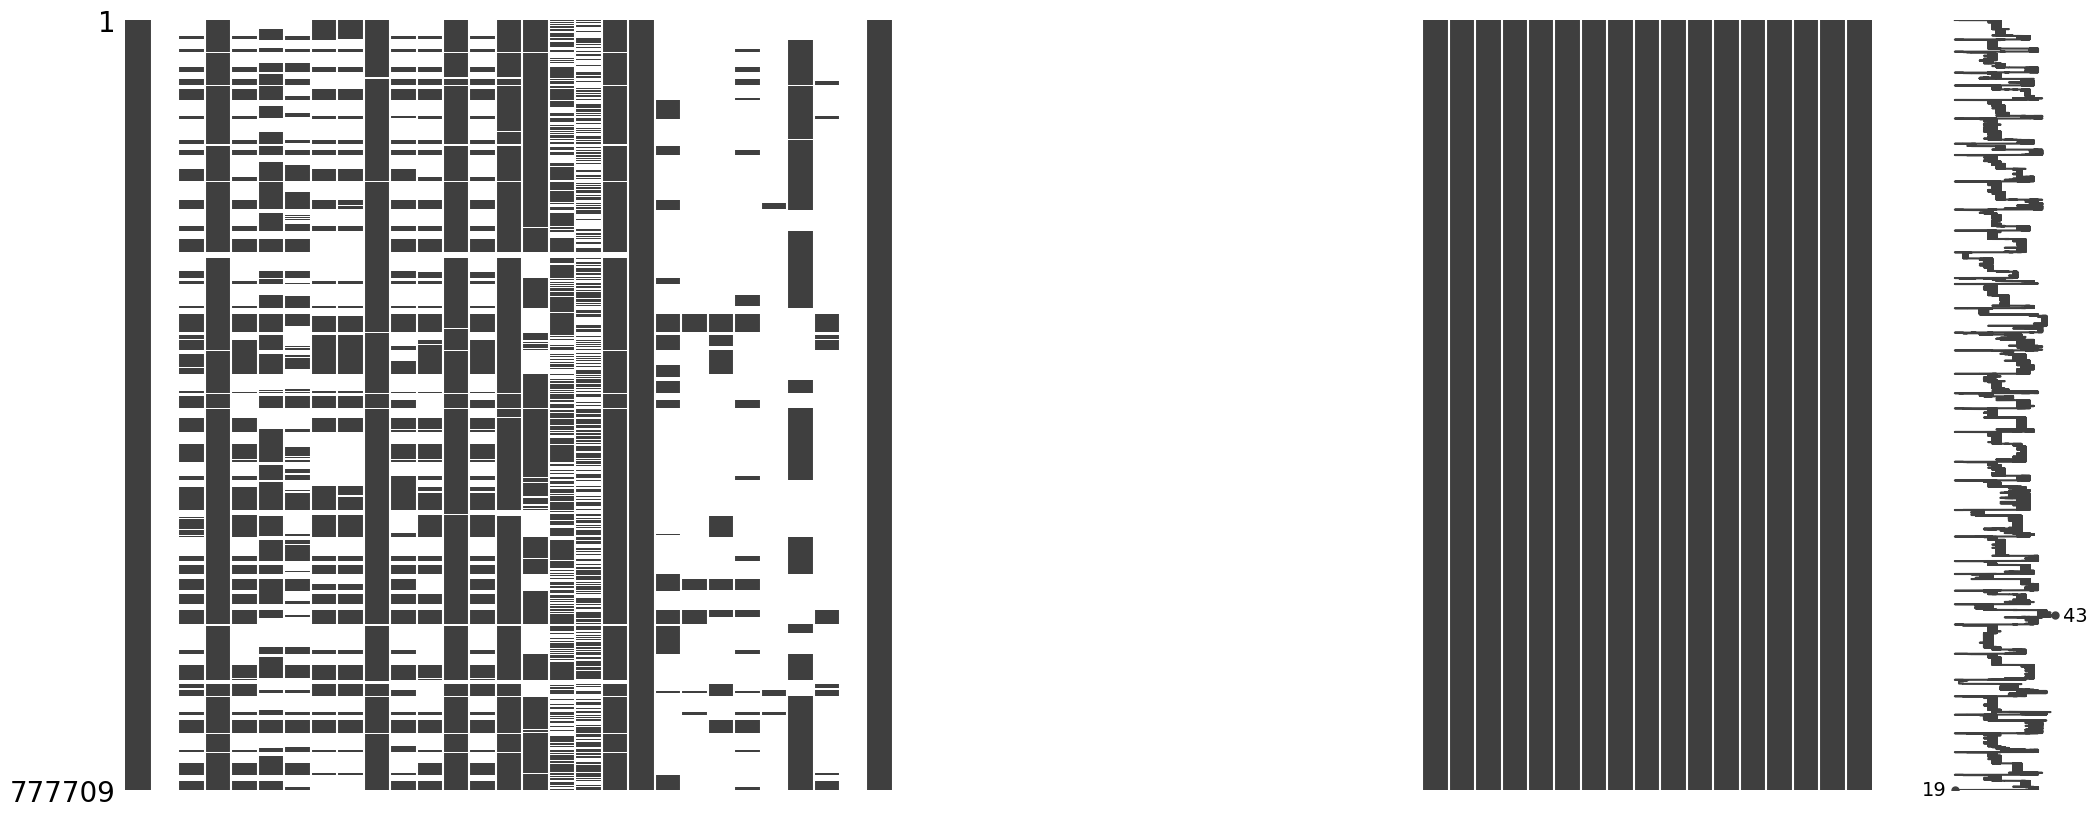

In [23]:
mn.matrix(df_filter)

In [24]:
def generate_slices(df_train, feature, target, filter = True):
    X_train = []
    index_arr = []
    for well_name in df_train.filename.unique():
        df_i = df_train[df_train.filename == well_name].copy()
        df_i = df_i[[target] + feature]

        
        x = df_i.values
        min_idx = x.shape[0] - (x.shape[0] // n) * n
        y = x[min_idx:,:].copy()
        
        idx_list = df_i.index[min_idx:].copy()
        y = y.reshape(-1, n, x.shape[1])

        #target_idx = list(df_i.columns).index(target)
        if filter:
            target_idx = 0
            mask = y[:,:, target_idx]
            mask = np.isnan(mask.astype('float64'))
            mask = mask.sum(axis = 1) < 0.9 * n
            n0 = y.shape[0]
            y = y[mask,:,:]
            n1 = y.shape[0]
            print(f'{well_name:20}: {n0:4} to {n1:4} segments')
        X_train.append(y.copy())
        index_arr.append(idx_list)

    X_train = np.concatenate(X_train, axis = 0)
    index_arr = np.concatenate(index_arr, axis = 0)
    
    return X_train, index_arr, [target] + feature
    

In [25]:
#df_train[encoded_columns] = enc.transform(df_train[features_one_hot_encode])[:, :-1]
df_train[features_scale] = scaler.transform(df_train[features_scale])

df_full = df.copy()
#df_full[encoded_columns] = enc.transform(df_full[features_one_hot_encode])[:, :-1]
df_full[features_scale] = scaler.transform(df_full[features_scale])

In [26]:
X_train, _, _ = generate_slices(df_train, feature = features, target = target)

35_11-12_logs.las   :  395 to   75 segments
25_11-24_logs.las   :  259 to  131 segments
16_2-11_A_logs.las  :  292 to   79 segments
16_10-5_logs.las    :  375 to   83 segments
34_4-10_R_logs.las  :  508 to   81 segments
31_3-4_logs.las     :  227 to  105 segments
33_6-3_S_logs.las   :  535 to  335 segments
34_12-1_logs.las    :  567 to  341 segments
35_6-2_S_logs.las   :  437 to  267 segments
32_2-1_logs.las     :  120 to    6 segments
34_3-1_A_logs.las   :  488 to  251 segments
31_2-19_S_logs.las  :  493 to  233 segments
35_11-6_logs.las    :  473 to  281 segments
7_1-2_S_logs.las    :  390 to   77 segments
25_6-3_logs.las     :  306 to  242 segments
35_8-6_S_logs.las   :  476 to   45 segments
34_3-3_A_logs.las   :  602 to  260 segments
35_9-8_logs.las     :  375 to  206 segments
35_4-1_logs.las     :  597 to  394 segments
34_10-35_logs.las   :  536 to   47 segments
35_3-7_S_logs.las   :  494 to  425 segments
16_2-6_logs.las     :  261 to   41 segments
35_11-10_logs.las   :  338 to  2

In [27]:
X_full, index_arr, columns_names = generate_slices(df_full, feature = features, target = target, filter = False)

In [28]:
X_train.shape, X_full.shape, index_arr.shape

((5171, 50, 5), (44201, 50, 5), (2210050,))

# GAIN

In [29]:
def generator_builder(num_fet = 80):
      # 80 * 2 = 162
  generator = keras.models.Sequential([
    keras.layers.Input(shape = num_fet * 2), 
    keras.layers.Dense(32, 'relu'),
    keras.layers.Dense(16, 'relu'),
    keras.layers.Dense(16, 'relu'),
    keras.layers.Dense(16, 'relu'),
    keras.layers.Dense(num_fet, 'linear')
  ])
  return generator

def discriminator_builder(num_fet = 80):
      # 80 * 2 = 162
  discriminator = keras.models.Sequential([
      keras.layers.Input(shape = num_fet * 2),
      keras.layers.Dense(32, 'relu'),
      keras.layers.Dense(16, 'relu'),
      keras.layers.Dense(16, 'relu'),
      keras.layers.Dense(num_fet, 'sigmoid'),
  ])

  return discriminator

In [ ]:
def discriminator_loss(m, m_hat):
    temp = tf.math.multiply(m, tf.math.log(m_hat + 1e-8))
    temp += tf.math.multiply(tf.ones_like(m) - m , tf.math.log(tf.ones_like(m_hat) - m_hat + 1e-8))
    return -tf.reduce_mean(temp)

In [ ]:
def generator_loss(m, m_hat, x, x_hat, alpha = 10):
    loss = -tf.math.multiply((tf.ones_like(m)-m), tf.math.log(m_hat+1e-8))
    loss += alpha * tf.multiply(m, (x - x_hat) ** 2)
    return tf.reduce_mean(loss)

In [ ]:
def hint_smapler(batch_size = 128, num_fet = 80, hint_rate = 0.9):
    A = np.random.uniform(0., 1., size = [batch_size, num_fet])
    B = hint_rate > A
    C = 1.*B
    return C

In [ ]:
# Change Optimizer and learning rate

In [ ]:
generator_optimizer = keras.optimizers.Adam(1e-6)
discriminator_optimizer = keras.optimizers.Adam(1e-6)

In [ ]:
generator = generator_builder(num_fet = n_features)
discriminator = discriminator_builder(num_fet = n_features)

In [ ]:
@tf.function
def train_step(batch, epoch_num):
    
    m = tf.where(tf.math.is_nan(batch), tf.zeros_like(batch), tf.ones_like(batch))
    batch_C = tf.where(tf.math.is_nan(batch), tf.zeros_like(batch), batch)
    z = np.random.uniform(0, 0.01, size = batch.shape)
    batch = tf.math.multiply(batch_C, m) + tf.math.multiply((tf.ones_like(m) - m), z)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        X_temp = tf.cast(generator(tf.concat([batch, m], 1), training = True), tf.float64)
        X_hat = tf.math.multiply(m, batch) + tf.math.multiply((tf.ones_like(m) - m), X_temp)

        H = tf.math.multiply(hint_smapler(n, n_features),  m)
        M_hat = tf.cast(discriminator(tf.concat([X_hat, H], 1), training = True), tf.float64)

        disc_loss = discriminator_loss(m, M_hat)
        gen_loss = generator_loss(m, M_hat, batch, X_hat, alpha = 10)

    gen_grad = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grad = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gen_grad, generator.trainable_variables))
    discriminator_optimizer.apply_gradients((zip(disc_grad, discriminator.trainable_variables)))
    return gen_loss, disc_loss

In [ ]:
def train(dataset, EPOCHS, model_filepath = None, n_epochs = 10):
    losses_gen = []
    losses_disc  = []
    for epoch in range(1, EPOCHS+1):
        try:
            print(f'Epoch {epoch} / {EPOCHS}:', end=' ')
            t0 = time.time()
            for batch in dataset:
                gen_loss, disc_loss = train_step(batch, epoch)
                losses_gen.append(gen_loss)
                losses_disc.append(disc_loss)
            t1 = time.time()
            print(f'gen_loss = {gen_loss}, disc_loss = {disc_loss}, time = {t1 - t0}')
            if (model_filepath is not None) and (epoch % n_epochs) == 0:
                generator.save(model_filepath + f'gen_{epoch}.h5')
                discriminator.save(model_filepath + f'disc_{epoch}.h5')
        except KeyboardInterrupt:
            break
    if (model_filepath is not None):
        generator.save(model_filepath + f'gen_{epoch}.h5')
        discriminator.save(model_filepath + f'disc_{epoch}.h5')
    return losses_gen, losses_disc

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(X_train).shuffle(n)

In [ ]:
gen_loss, disc_loss = train(train_data, EPOCHS = 60, model_filepath = '/home/geouser05/geo/data/06_model/', n_epochs = 5)

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(gen_loss, color = 'orange')
plt.title('Generator Loss')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(disc_loss, color = 'orange')
plt.title('Disciriminator Loss')
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.show()

In [ ]:
generated_data = []
for batch in X_full:
    m = tf.where(tf.math.is_nan(batch), tf.zeros_like(batch), tf.ones_like(batch))
    batch_C = tf.where(tf.math.is_nan(batch), tf.zeros_like(batch), batch)
    z = np.random.uniform(0, 0.01, size = batch.shape)
    batch = tf.math.multiply(batch_C, m) + tf.math.multiply((tf.ones_like(m) - m), z)
    generated_data.append(batch.numpy().copy())
generated_data = np.concatenate(generated_data, axis = 0)

In [ ]:
generated_data.shape

In [ ]:
df_generated = pd.DataFrame(generated_data, columns = [str(x) + '_PRED_GAIN' for x in columns_names], index = index_arr)

In [ ]:
df_out = pd.merge(df, df_generated, left_index = True, right_index = True, how = 'left')

In [ ]:
df_out.to_csv('/home/geouser05/geo/data/07_model_output/prediction_dts_full2_gain.csv')

In [ ]:
df_out.shape